In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [103]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
from sklego.metrics import p_percent_score
from statistics import mean
from sklego.metrics import equal_opportunity_score

In [104]:
from sklego.preprocessing import InformationFilter
from sklearn.model_selection import RandomizedSearchCV

In [105]:
from sklearn.linear_model import LogisticRegression
from sklego.linear_model import DemographicParityClassifier
from sklego.linear_model import EqualOpportunityClassifier

In [106]:
import os
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [107]:
import shap

In [108]:
import ipywidgets

In [109]:
# protected attributes: race and sex
cols = ["age", "workclass", "fnlwgt", "education", "educational-num", "marital-status", "occupation", "relationship", "race", "gender", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]

In [110]:
# load data
df = pd.read_csv("/Users/jobo/Desktop/adult.csv", header=0, delimiter=',')

In [111]:
df.head(10)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K
6,29,?,227026,HS-grad,9,Never-married,?,Unmarried,Black,Male,0,0,40,United-States,<=50K
7,63,Self-emp-not-inc,104626,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,32,United-States,>50K
8,24,Private,369667,Some-college,10,Never-married,Other-service,Unmarried,White,Female,0,0,40,United-States,<=50K
9,55,Private,104996,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,10,United-States,<=50K


In [112]:
df.shape

(48842, 15)

In [113]:
num_features = ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']

In [114]:
cat_features = ['workclass', 'marital-status', 'occupation', 'relationship', 'native-country', 'race']

## Data Cleaning

### Handling Missing Data

In [115]:
# format of missing data:
question_mark = df.loc[4, 'workclass']

In [116]:
# find features that have missing data
features_missing_data = {}
indices_missing_data = []
for index, row in df.iterrows():
    for col in cols:
        if row[col] == question_mark:
            indices_missing_data.append(index)
            if col in features_missing_data:
                features_missing_data[col] += 1
            else:
                features_missing_data[col] = 1

In [117]:
# nativecountry, workclass, and occupation are the 3 features that contain missing data
features_missing_data

{'workclass': 2799, 'occupation': 2809, 'native-country': 857}

In [118]:
# check what percentage of rows have missing data
percent_rows_missing_data = len(set(indices_missing_data))/df.shape[0]
percent_rows_missing_data

0.07411653904426518

Note: ~7% of the rows having missing data. Three main options come to mind for how to handle this missing data:
1. Remove missing data 
2. Replace missing data with most frequent values from that column (given that all three features with missing data are categorical)
3. Replace missing data such that the distribution of the missing dataset closely resembles the distribution of the non-missing dataset

Lets check how the distributions of gender, income, and race in the missing data compare to that of the original data

In [119]:
indices_missing_unique = list(set(indices_missing_data))

In [120]:
df_missing_data = df.iloc[indices_missing_unique]

### Distribution of gender in missing dataset

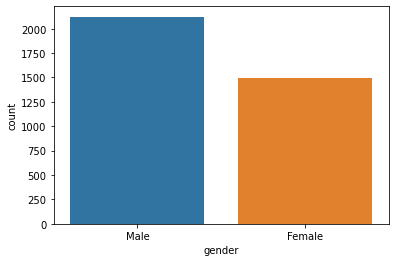

In [121]:
sns.countplot(x="gender", data= df_missing_data)
plt.show()

### Distribution of gender in original dataset

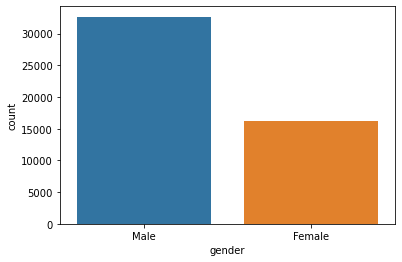

In [77]:
sns.countplot(x="gender", data= df)
plt.show()

### Distribution of income in missing dataset

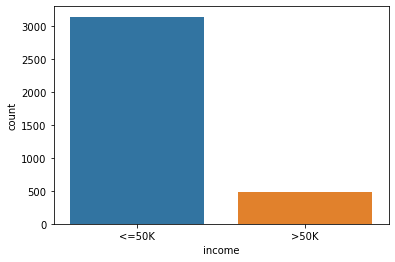

In [78]:
sns.countplot(x="income", data= df_missing_data)
plt.show()

### Distribution of income in original dataset

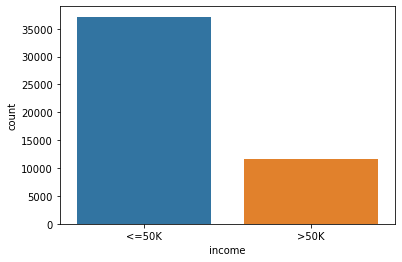

In [79]:
sns.countplot(x="income", data= df)
plt.show()

### Distribution of race in missing dataset

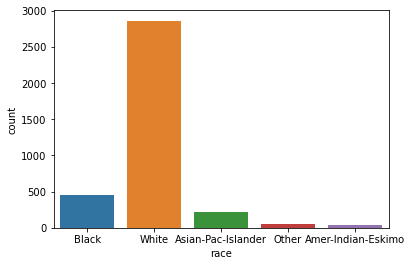

In [80]:
sns.countplot(x="race", data= df_missing_data)
plt.show()

### Distribution of race in original dataset

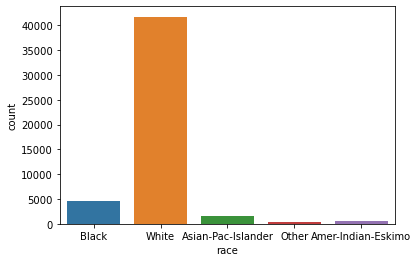

In [81]:
sns.countplot(x="race", data= df)
plt.show()

The distribution of the gender, income, and race in the missing datasets are similar enough to the respective distributions of the original dataset. For this reason, as well as the fact that a relatively small portion of the rows have missing values (~7%), I will remove the rows with missing data.

In [122]:
# remove rows which contain missing data
df = df.drop(df[df.workclass == question_mark].index)
df = df.drop(df[df.occupation == question_mark].index)
df = df.drop(df[df["native-country"] == question_mark].index)

In [123]:
df.shape

(45222, 15)

## Feature Engineering

In [124]:
df['education'].value_counts()

HS-grad         14783
Some-college     9899
Bachelors        7570
Masters          2514
Assoc-voc        1959
11th             1619
Assoc-acdm       1507
10th             1223
7th-8th           823
Prof-school       785
9th               676
12th              577
Doctorate         544
5th-6th           449
1st-4th           222
Preschool          72
Name: education, dtype: int64

In [125]:
df['educational-num'].value_counts()

9     14783
10     9899
13     7570
14     2514
11     1959
7      1619
12     1507
6      1223
4       823
15      785
5       676
8       577
16      544
3       449
2       222
1        72
Name: educational-num, dtype: int64

Educational number and education are essentially providing the same information. For this reason, and remove education. I choose to remove education because I would rather have a continuous variable than a categorical variable that I would need to one-hot encode.

In [126]:
# remove education feature
df = df.drop('education', 1)

### Marital-Status

In [127]:
df['marital-status'].value_counts()

Married-civ-spouse       21055
Never-married            14598
Divorced                  6297
Separated                 1411
Widowed                   1277
Married-spouse-absent      552
Married-AF-spouse           32
Name: marital-status, dtype: int64

In order to make one-hot encoding simpler, I will condense marital-status into the following four categories:
1. married ( Married-civ-spouse, Married-spouse-absent, Married-AF-spouse)
2. separated (Divorced, Separated)
3. never-married
4. widowed

In [128]:
married= ['Married-civ-spouse','Married-spouse-absent','Married-AF-spouse']
separated  = ['Divorced', 'Separated']

df['marital-status'].replace(to_replace = married ,value = 'Married',inplace = True)
df['marital-status'].replace(to_replace = separated,value = 'Separated',inplace = True)

In [129]:
df['marital-status'].value_counts()

Married          21639
Never-married    14598
Separated         7708
Widowed           1277
Name: marital-status, dtype: int64

### Workclass

In [130]:
df['workclass'].value_counts()

Private             33307
Self-emp-not-inc     3796
Local-gov            3100
State-gov            1946
Self-emp-inc         1646
Federal-gov          1406
Without-pay            21
Name: workclass, dtype: int64

I will condense workclass into the following 3 categories:
1. Self-employed (Self-emp-not-inc, Self-emp-inc)
2. Government (Local-gov, State-gov, Federal-gov)
3. Private
4. Without-pay

In [131]:
self_employed = ['Self-emp-not-inc','Self-emp-inc']
government_employees = ['Local-gov','State-gov','Federal-gov']

df['workclass'].replace(to_replace = self_employed ,value = 'Self_employed',inplace = True)
df['workclass'].replace(to_replace = government_employees,value = 'Govt_employees',inplace = True)

In [132]:
df['workclass'].value_counts()

Private           33307
Govt_employees     6452
Self_employed      5442
Without-pay          21
Name: workclass, dtype: int64

### Native country

In [133]:
df['native-country'].value_counts()

United-States                 41292
Mexico                          903
Philippines                     283
Germany                         193
Puerto-Rico                     175
Canada                          163
El-Salvador                     147
India                           147
Cuba                            133
England                         119
China                           113
Jamaica                         103
South                           101
Italy                           100
Dominican-Republic               97
Japan                            89
Guatemala                        86
Vietnam                          83
Columbia                         82
Poland                           81
Haiti                            69
Portugal                         62
Iran                             56
Taiwan                           55
Greece                           49
Nicaragua                        48
Peru                             45
Ecuador                     

Given that each country outside of US accounts for less than 2% of the dataset, I will condense these category into the following 2 categories:
1. US
2. Not US

In [134]:
not_us = []
for country in df['native-country'].unique():
    if country != 'United-States':
        not_us.append(country)
df['native-country'].replace(to_replace = not_us ,value = 'Not United-States',inplace = True)

In [135]:
df['native-country'].value_counts()

United-States        41292
Not United-States     3930
Name: native-country, dtype: int64

### Race

For the purposes of this exploration, we will only be considering the following races: 
1. White
2. Black

In [136]:
df['race'].value_counts()

White                 38903
Black                  4228
Asian-Pac-Islander     1303
Amer-Indian-Eskimo      435
Other                   353
Name: race, dtype: int64

In [137]:
df.drop(df.loc[df['race'] == 'Asian-Pac-Islander'].index, inplace=True)
df.drop(df.loc[df['race'] == 'Amer-Indian-Eskimo'].index, inplace=True)
df.drop(df.loc[df['race'] == 'Other'].index, inplace=True)

In [138]:
df['race'].value_counts()

White    38903
Black     4228
Name: race, dtype: int64

## Resample?

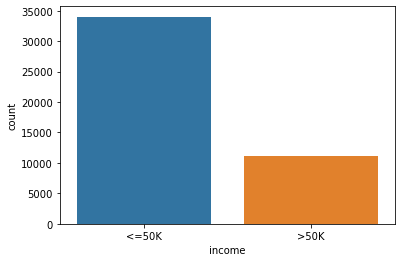

In [139]:
sns.countplot(x="income", data= df)
plt.show()

There is a significant disparity in outcome classes, which could lead to our models being biased towards the majority class (<=50K). Thus, it could be worth resampling using undersampling or oversampling techniques. 

Note:
Undersampling: Removing instances from the majority class in order to balance out the distribution of outcome classes.
Oversampling: Increasing the number of samples in the minority class to balance out the distribution of outcome classes. This can be done by adding duplicates to the minority class.

In [139]:
# convert categorical variables into numerical variables through one-hot encoding
df = pd.get_dummies(df, columns = cat_features)

In [140]:
# convert gender into a binary column
df['gender'] = LabelEncoder().fit_transform(df['gender'])
# convert income label into a binary column
df['income'] = LabelEncoder().fit_transform(df['income'])

In [143]:
# scale numerical data
df[num_features] = StandardScaler().fit_transform(df[num_features])

In [144]:
df.head(20)

,age,fnlwgt,educational-num,gender,capital-gain,capital-loss,hours-per-week,income,workclass_Govt_employees,workclass_Private,...,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,native-country_Not United-States,native-country_United-States,race_Black,race_White
0,-1.027432,0.334836,-1.227877,1,-0.147204,-0.219457,-0.080446,0,0,1,...,0,0,0,1,0,0,0,1,1,0
1,-0.046890,-0.957670,-0.437925,1,-0.147204,-0.219457,0.751002,0,0,1,...,1,0,0,0,0,0,0,1,0,1
2,-0.801153,1.374112,0.747003,1,-0.147204,-0.219457,-0.080446,1,1,0,...,1,0,0,0,0,0,0,1,0,1
3,0.405668,-0.292405,-0.042949,1,0.884013,-0.219457,-0.080446,1,0,1,...,1,0,0,0,0,0,0,1,1,0
5,-0.348595,0.069623,-1.622853,1,-0.147204,-0.219457,-0.911894,0,0,1,...,0,1,0,0,0,0,0,1,0,1
7,1.838769,-0.817916,1.931931,1,0.269012,-0.219457,-0.745605,1,0,0,...,1,0,0,0,0,0,0,1,0,1
8,-1.102859,1.682794,-0.042949,0,-0.147204,-0.219457,-0.080446,0,0,1,...,0,0,0,0,1,0,0,1,0,1
9,1.235358,-0.814425,-2.412805,1,-0.147204,-0.219457,-2.574791,0,0,1,...,1,0,0,0,0,0,0,1,0,1
10,1.989621,-0.064725,-0.437925,1,0.713664,-0.219457,-0.080446,1,0,1,...,1,0,0,0,0,0,0,1,0,1
11,-0.197743,0.199564,1.141979,1,-0.147204,-0.219457,-0.080446,0,1,0,...,1,0,0,0,0,0,0,1,0,1


In [151]:
x = df.drop('income', axis = 1)

In [152]:
y = df.income

In [153]:
# used to compute p_percent_score
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.2, random_state = 0)

# Modeling

In [154]:
# classifiers
classifiers=['Logistic Regression', 'Demographic Parity']

In [155]:
models=[LogisticRegression(max_iter=5000),DemographicParityClassifier(sensitive_cols=['gender'], covariance_threshold=0.0000069)]

In [156]:
# define cross-validation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

In [157]:
# model evaluation metrics 
#f2 = make_scorer(fbeta_score, beta=2)
mean_accuracy=[]
#mean_f2=[]
mean_precision=[]
mean_recall=[]
accuracy_std=[]
p_percents_sex=[]
#p_percents_race=[]
#equal_opp_sex=[]
#equal_opp_race=[]

In [158]:
for model in models:
    # accuracy
    cv_accuracy = cross_val_score(model,x,y,scoring = "accuracy", cv = cv, n_jobs=-1)
    # f2beta
    #cv_f2 = cross_val_score(model, x, y, scoring=f2, cv=cv, n_jobs=-1)
    # precision
    cv_precision = cross_val_score(model, x, y, scoring='precision', cv=cv, n_jobs=-1)
    # recall
    cv_recall = cross_val_score(model, x, y, scoring='recall', cv=cv, n_jobs=-1)
    #p% 
    model.fit(xtrain, ytrain)
    p_percent_sex = p_percent_score(sensitive_column="gender")(model, xtest, ytest)
    #p_percent_race = p_percent_score(sensitive_column="race")(model, xtrain, ytrain)
    
    #equal_opp_score_sex = equal_opportunity_score(sensitive_column="sex")(model, xtrain, ytrain)
    #equal_opp_score_race = equal_opportunity_score(sensitive_column="race")(model, xtrain, ytrain)
    


    mean_accuracy.append(mean(cv_accuracy))
    accuracy_std.append(cv_accuracy.std())
    #mean_f2.append(mean(cv_f2))
    mean_precision.append(mean(cv_precision))
    mean_recall.append(mean(cv_recall))
    p_percents_sex.append(p_percent_sex)
    #p_percents_race.append(p_percent_race)
    #equal_opp_sex.append(equal_opp_score_sex)
    #equal_opp_race.append(equal_opp_score_race)

In [159]:
models_dataframe=pd.DataFrame({'Mean Accuracy':mean_accuracy, 'Accuracy Std':accuracy_std, 'Mean Precision':mean_precision, 'Mean Recall':mean_recall,  'P% sex':p_percents_sex},index=classifiers)

## Benchmark results

In [160]:
df['gender'].value_counts()

1    29164
0    13967
Name: gender, dtype: int64

In [161]:
df.groupby(['gender','income']).size()

gender  income
0       0         12386
        1          1581
1       0         20004
        1          9160
dtype: int64

Baseline comparison for accuracy: If we were to predict positive outcome 

Baseline comparison for p percentage relative to gender: if our model was 100% accurate, the following would be our p percent score for gender:

In [162]:
# positive outcome female / total female
p_y1_z0 = 1581/13967
# positive outcome male / total male 
p_y1_z1 = 9160/29164
dataset_p_percent = np.minimum(p_y1_z1 / p_y1_z0, p_y1_z0 / p_y1_z1)
dataset_p_percent

0.36039632408643835

In [163]:
models_dataframe

,Mean Accuracy,Accuracy Std,Mean Precision,Mean Recall,P% sex
Logistic Regression,0.847017,0.003754,0.734303,0.604507,0.287016
Demographic Parity,0.831567,0.003065,0.728192,0.516464,0.797039


## Exploration of how feature importance changes as a function of fairness for gender

For this exploration, I will train 60 different DemographicParityClassifier models, each with a different covariance threshold ranging between 0-1, to plot out how feature importance for each feature changes relative to fairness

In [167]:
dpc_features = x.columns.drop('gender')

In [168]:
# create dictionary where keys are features, and values are an empty list (to be populated later on)
feature_dict = {}
for feat in dpc_features:
    feature_dict[feat] = []
feature_dict

{'age': [],
 'fnlwgt': [],
 'educational-num': [],
 'capital-gain': [],
 'capital-loss': [],
 'hours-per-week': [],
 'workclass_Govt_employees': [],
 'workclass_Private': [],
 'workclass_Self_employed': [],
 'workclass_Without-pay': [],
 'marital-status_Married': [],
 'marital-status_Never-married': [],
 'marital-status_Separated': [],
 'marital-status_Widowed': [],
 'occupation_Adm-clerical': [],
 'occupation_Armed-Forces': [],
 'occupation_Craft-repair': [],
 'occupation_Exec-managerial': [],
 'occupation_Farming-fishing': [],
 'occupation_Handlers-cleaners': [],
 'occupation_Machine-op-inspct': [],
 'occupation_Other-service': [],
 'occupation_Priv-house-serv': [],
 'occupation_Prof-specialty': [],
 'occupation_Protective-serv': [],
 'occupation_Sales': [],
 'occupation_Tech-support': [],
 'occupation_Transport-moving': [],
 'relationship_Husband': [],
 'relationship_Not-in-family': [],
 'relationship_Other-relative': [],
 'relationship_Own-child': [],
 'relationship_Unmarried': [],

In [169]:
cov_threshold = np.linspace(0,1,60)

NOTE: Features that are binary variables (e.g. relationship_husband) will need larger coefficients to affect 
the final outcome, while features that contain a wide range of values (e.g. age) will have significant
impact on the final prediction even when coefficient is small.
Therefore, we are measuring the overall importance of a feature by multiplying 
feature weight * absolute value of that feature's column

In [170]:
# build demographic parity models with 60 different covariance thresholds, storing each corresponding
# feature coefficient in the above dictionary, allowing us to see how each feature's importance changes as a function
# of covariance threshold 
for cov in cov_threshold:
    model = DemographicParityClassifier(sensitive_cols="gender", covariance_threshold=cov)
    model.fit(x, y)
    p_percent = p_percent_score(sensitive_column="gender")(model, x)
    for coef, feat in zip(model.coef_[0,:],dpc_features):
        feature_dict[feat].append([cov,coef*abs(df[feat].mean()),p_percent])

In [171]:
# format = {'feature': [covariance threshold, feature coef * average abs of feature column, p_percent]}
feature_dict['age']

[[0.0, 1.6361946203990677e-17, 0.7778474070984537],
 [0.01694915254237288, 1.6394734387794582e-17, 0.7588559933581176],
 [0.03389830508474576, 1.644627678583942e-17, 0.7346485648013669],
 [0.05084745762711865, 1.651467852891783e-17, 0.7059422715391901],
 [0.06779661016949153, 1.659899762145203e-17, 0.6763901969171534],
 [0.0847457627118644, 1.6698896046610055e-17, 0.6500016887071078],
 [0.1016949152542373, 1.6814216801550204e-17, 0.6191454918755345],
 [0.11864406779661017, 1.6944794143484683e-17, 0.5911786746903924],
 [0.13559322033898305, 1.709037654677701e-17, 0.5617754035609662],
 [0.15254237288135594, 1.7250597879561482e-17, 0.5380429935725689],
 [0.1694915254237288, 1.7424968878804966e-17, 0.5124460183823266],
 [0.1864406779661017, 1.7612876866731078e-17, 0.485537560497823],
 [0.2033898305084746, 1.781358984539734e-17, 0.4601769820868073],
 [0.22033898305084745, 1.802626183994549e-17, 0.43622522088974947],
 [0.23728813559322035, 1.824993875076988e-17, 0.41629138484655964],
 [0.254

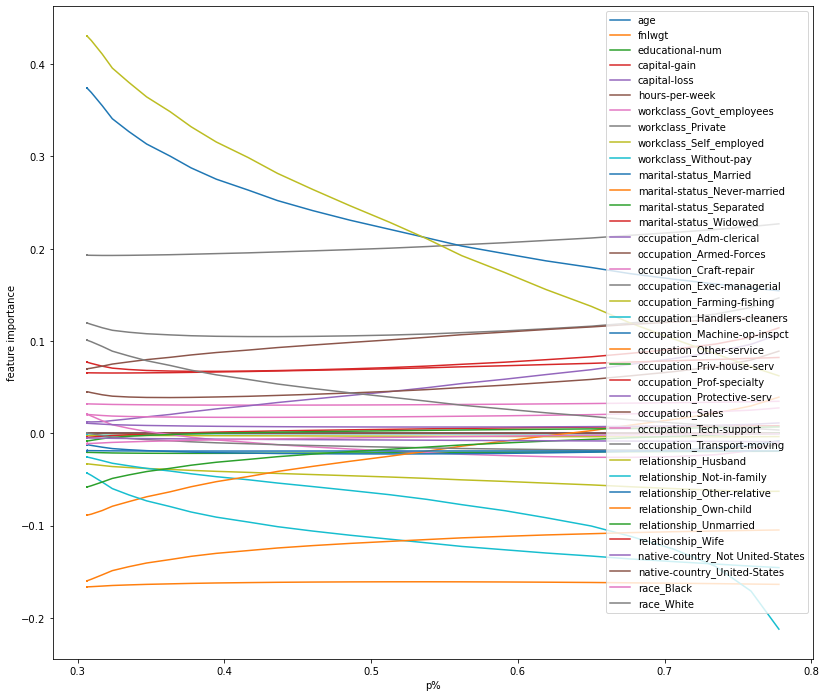

In [172]:
plt.figure(figsize=(30,12))
plt.subplot(121)

for feature in feature_dict:
    xs = [x[2] for x in feature_dict[feature]]
    ys = [x[1] for x in feature_dict[feature]]
    plt.plot(xs,ys,label=feature)
plt.xlabel("p%")
plt.ylabel('feature importance')
plt.legend()

In [179]:
for feature in feature_dict:
    print(feature)

age
fnlwgt
educational-num
capital-gain
capital-loss
hours-per-week
workclass_Govt_employees
workclass_Private
workclass_Self_employed
workclass_Without-pay
marital-status_Married
marital-status_Never-married
marital-status_Separated
marital-status_Widowed
occupation_Adm-clerical
occupation_Armed-Forces
occupation_Craft-repair
occupation_Exec-managerial
occupation_Farming-fishing
occupation_Handlers-cleaners
occupation_Machine-op-inspct
occupation_Other-service
occupation_Priv-house-serv
occupation_Prof-specialty
occupation_Protective-serv
occupation_Sales
occupation_Tech-support
occupation_Transport-moving
relationship_Husband
relationship_Not-in-family
relationship_Other-relative
relationship_Own-child
relationship_Unmarried
relationship_Wife
native-country_Not United-States
native-country_United-States
race_Black
race_White


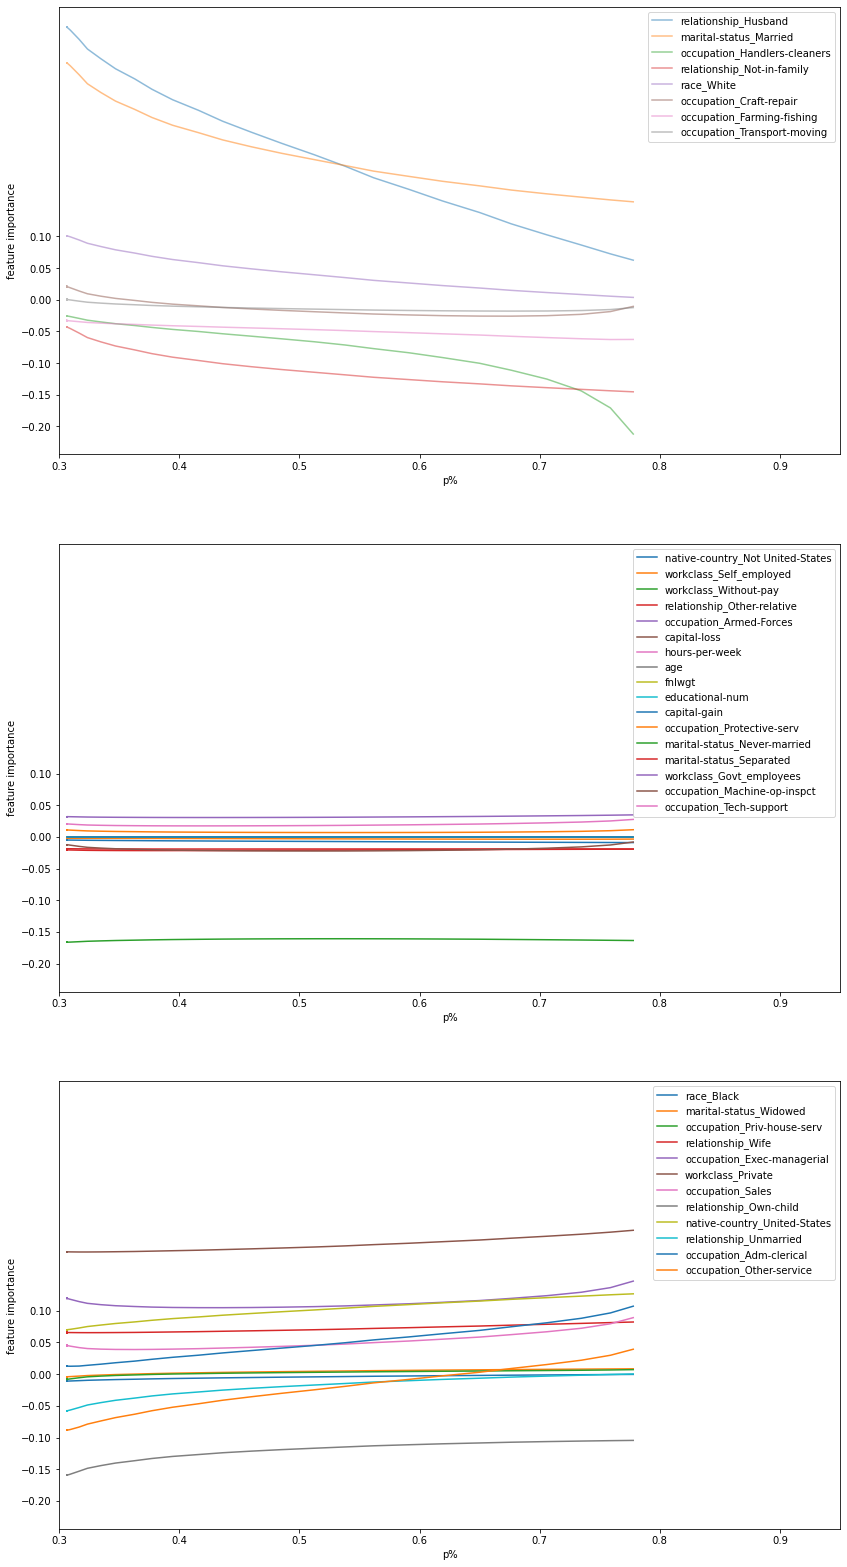

In [183]:
fig, ax = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(14,28))



#plt.figure(figsize=(18,7))
#plt.subplot(121, sharex=True, sharey=True)

for feature in ['relationship_Husband', 'marital-status_Married', 'occupation_Handlers-cleaners', 'relationship_Not-in-family', 'race_White', 'occupation_Craft-repair', 'occupation_Farming-fishing', 'occupation_Transport-moving']:
    xs = [x[2] for x in feature_dict[feature]]
    ys = [x[1] for x in feature_dict[feature]]
    ax[0].plot(xs,ys,alpha=0.5, label=feature)

plt.xlabel("p%")
plt.ylabel('feature importance')
plt.xlim((0.3, 0.95))
ax[0].legend()
ax[0].set_xlabel("p%")
ax[0].set_ylabel("feature importance")
ax[0].tick_params(labelbottom=True)
# plt.subplot(122)
for feature in ['native-country_Not United-States', 'workclass_Self_employed', 'workclass_Without-pay', 'relationship_Other-relative', 'occupation_Armed-Forces', 'capital-loss', 'hours-per-week', 'age', 'fnlwgt', 'educational-num','capital-gain', 'occupation_Protective-serv', 'marital-status_Never-married','marital-status_Separated', 'workclass_Govt_employees', 'occupation_Machine-op-inspct', 'occupation_Tech-support' ]:
    xs = [x[2] for x in feature_dict[feature]]
    ys = [x[1] for x in feature_dict[feature]]
    ax[1].plot(xs,ys,label=feature)
ax[1].legend()
ax[1].set_xlabel("p%")
ax[1].set_ylabel("feature importance")
ax[1].tick_params(labelbottom=True)
for feature in ['race_Black', 'marital-status_Widowed', 'occupation_Priv-house-serv', 'relationship_Wife', 'occupation_Exec-managerial', 'workclass_Private', 'occupation_Sales', 'relationship_Own-child', 'native-country_United-States', 'relationship_Unmarried', 'occupation_Adm-clerical', 'occupation_Other-service']:
    xs = [x[2] for x in feature_dict[feature]]
    ys = [x[1] for x in feature_dict[feature]]
    ax[2].plot(xs,ys,label=feature)
ax[2].legend()
ax[2].set_xlabel("p%")
ax[2].set_ylabel("feature importance")
ax[2].tick_params(labelbottom=True)
#for feature in list(feature_dict.keys())[30:41]:
#    xs = [x[2] for x in feature_dict[feature]]
#    ys = [x[1] for x in feature_dict[feature]]
#    ax[3].plot(xs,ys,label=feature)
#ax[3].legend()
# plt.xlabel("p%")
# plt.ylabel('feature importance')
# plt.ylim((-0.6,0.6))
ax[2].yaxis.set_ticks(np.linspace(-0.2,0.1,7))
#plt.legend()

In [184]:
# creating a pandas df for each feature
df_list = []
delta_list = []
for feature in feature_dict:
    df = pd.DataFrame(data = feature_dict[feature], columns = ["cov", f"{feature}_importance", "p percent"])
    df.sort_values('p percent')
    df = df.reset_index(drop=True)
    most_fair = df.at[0,f"{feature}_importance"]
    least_fair = df.at[59, f"{feature}_importance"]
    fairness_delta = most_fair - least_fair
    delta_list.append(fairness_delta)    
feature_fairness_delta = list(zip(feature_dict.keys(),delta_list))
feature_fairness_delta_sort = sorted(feature_fairness_delta, key=lambda x : x[1])
#feature_fairness_delta_sort
features = []
delta_importance = []
for item in feature_fairness_delta_sort:
    features.append(item[0])
    delta_importance.append(item[1])

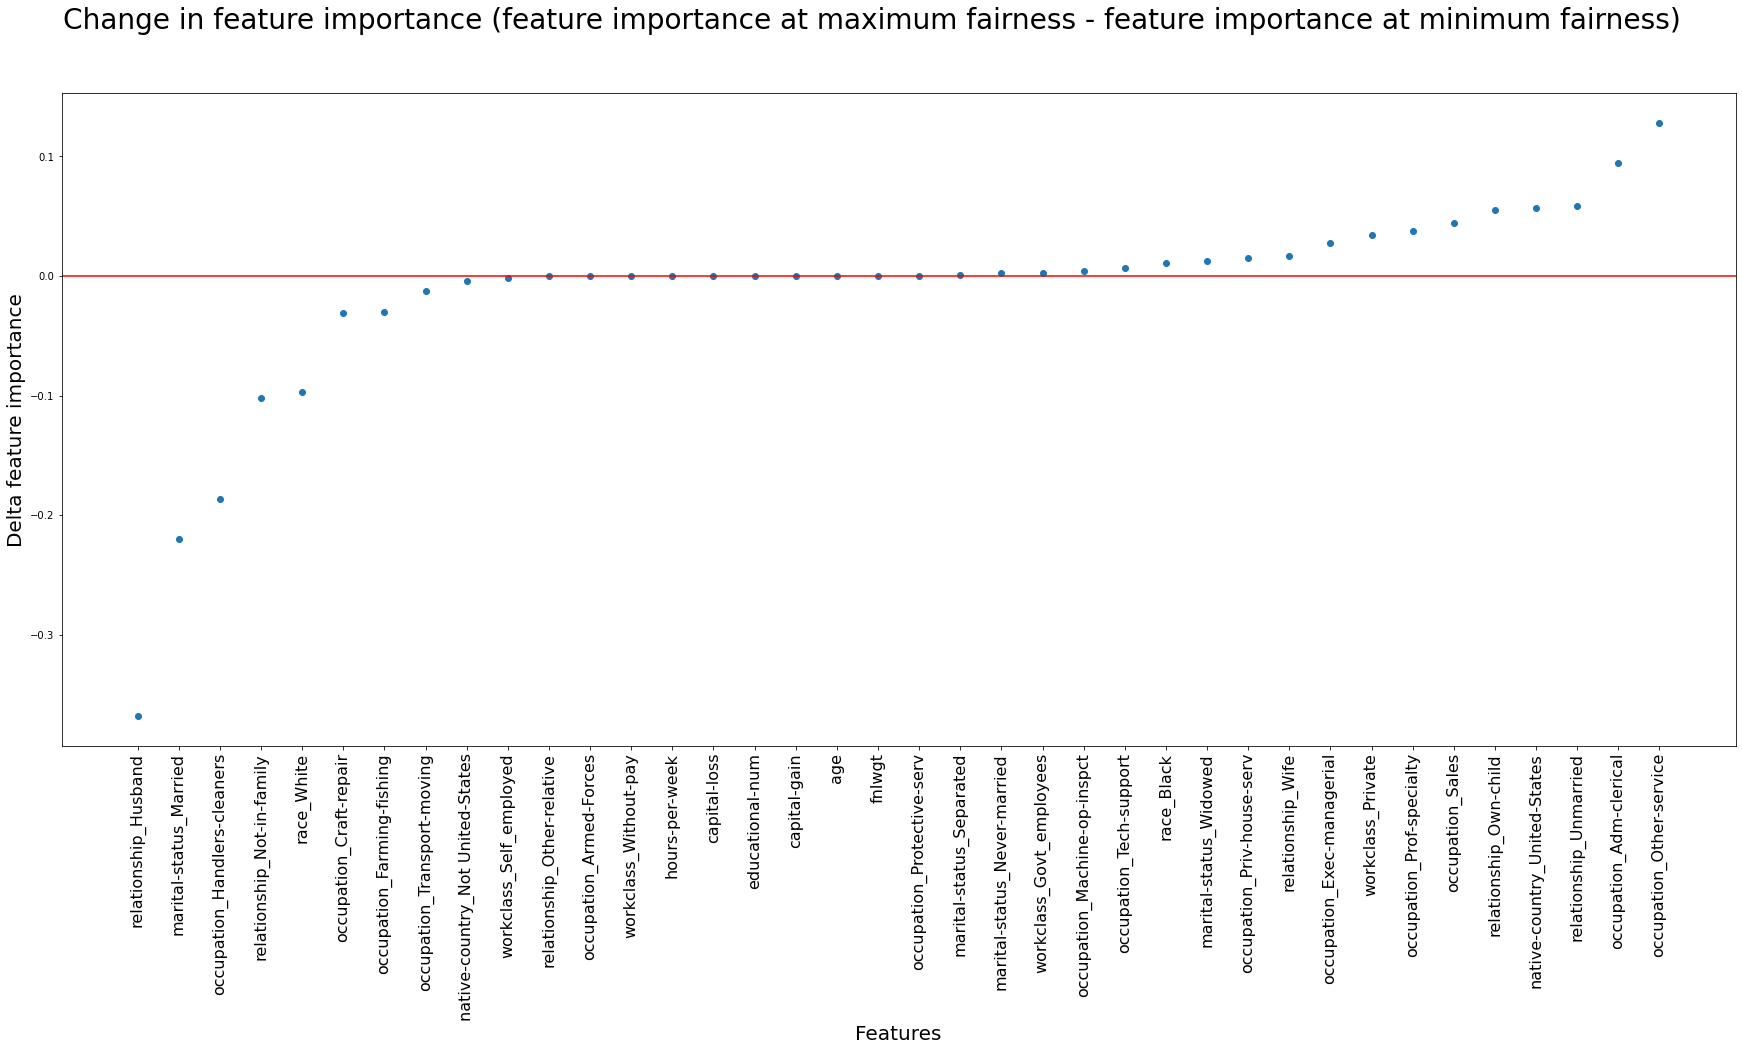

In [185]:
figure, ax = plt.subplots(figsize=(30,12))
ax.scatter(features, delta_importance)
xticks_labels = features
ax.set_xticklabels(xticks_labels, rotation=90, fontsize=16)
figure.suptitle('Change in feature importance (feature importance at maximum fairness - feature importance at minimum fairness)', fontsize=28)
plt.xlabel("Features", fontsize=20)
plt.ylabel('Delta feature importance', fontsize=20)
ax.axhline(y=0, color="red")
plt.show()

# Using SHAP to calculate feature importance

Referencing Begley et al., 2020 (https://arxiv.org/abs/2010.07389), it seemed useful to incorporate shapley values as measures of feature importance for the above exploration of feature importance as a function of fairness. However, in testig out the most well-know module for computing shapley values for machine learning models, https://github.com/slundberg/shap, it became clear that the runtime performance would be a significant road block. That is, it took 15 minutes to compute shapley values for only 7 of the 9045 samples in my testing set for one model. Attempting to compute shapley values for 60 different DemographicParityClassifier models in order to recreate the above exploration using shapley values does not seem realistic at the moment. I will try to find a work around for this, but nothing promising as come to light yet.

In [50]:
model = LogisticRegression(max_iter=5000)

In [51]:
model.fit(xtrain,ytrain)

LogisticRegression(max_iter=5000)

In [52]:
model.predict

<bound method LinearClassifierMixin.predict of LogisticRegression(max_iter=5000)>

In [53]:
explainer = shap.KernelExplainer(model.predict, xtest)

Using 9045 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [55]:
shap_values = explainer.shap_values(xtest)

  0%|          | 0/9045 [00:00<?, ?it/s]

KeyboardInterrupt: 